# Predicting Apple (AAPL) Stock Trends with LSTM: 10-Year Historical Analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/Users/vinsonnguyen/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


We are gonna use the Python's yfinance library to get historic price data for APPLE **(AAPL)**. We are gonna be looking at the past 10 years.

In [2]:
news_data = yf.download(
    tickers = 'AAPL',
    start = '2015-01-01',
    end = '2025-01-01',
    interval = '1d',
    auto_adjust = True
).dropna()

[*********************100%***********************]  1 of 1 completed


In [3]:
news_data

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.261045,24.729268,23.821670,24.718172,212818400
2015-01-05,23.577572,24.110148,23.391171,24.030261,257142000
2015-01-06,23.579790,23.839420,23.218081,23.641924,263188400
2015-01-07,23.910442,24.010300,23.677440,23.788393,160423600
2015-01-08,24.829124,24.886821,24.121242,24.238854,237458000
...,...,...,...,...,...
2024-12-24,257.286652,257.296596,254.386927,254.586231,23234700
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100


## Plotting High and Low Prices
- Good for volatility/intraday risk

In [4]:
dates = news_data.index.date
high_prices = news_data['High']
low_prices = news_data['Low']

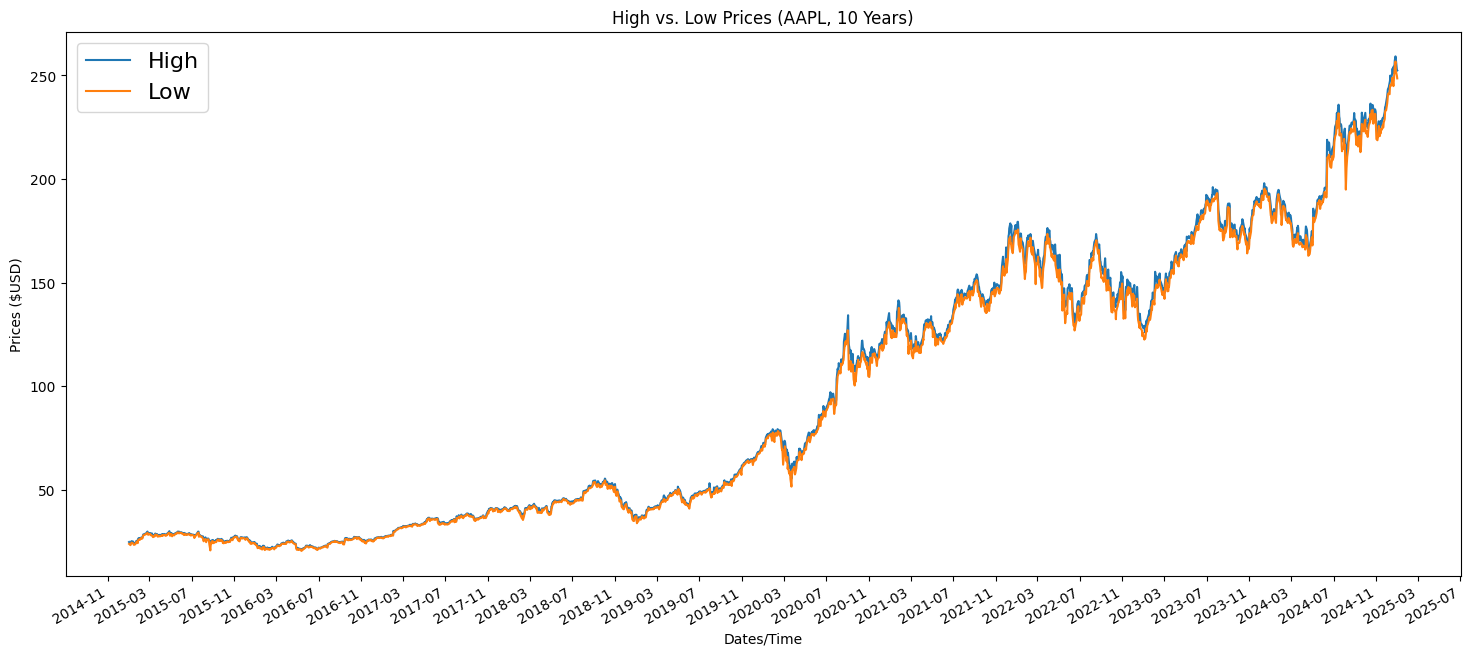

In [5]:
plt.figure(figsize = (18, 8)) 
plt.plot(dates, high_prices, label = 'High')
plt.plot(dates, low_prices, label = 'Low')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('High vs. Low Prices (AAPL, 10 Years)')
plt.xlabel('Dates/Time')
plt.ylabel('Prices ($USD)')
plt.legend(fontsize = 16)

plt.gcf().autofmt_xdate()
plt.show()

## Plotting Closing and Opening Prices
- Good for overnight sentiment 

In [6]:
dates = news_data.index.date
closing_prices = news_data['Close']
opening_prices = news_data['Open']

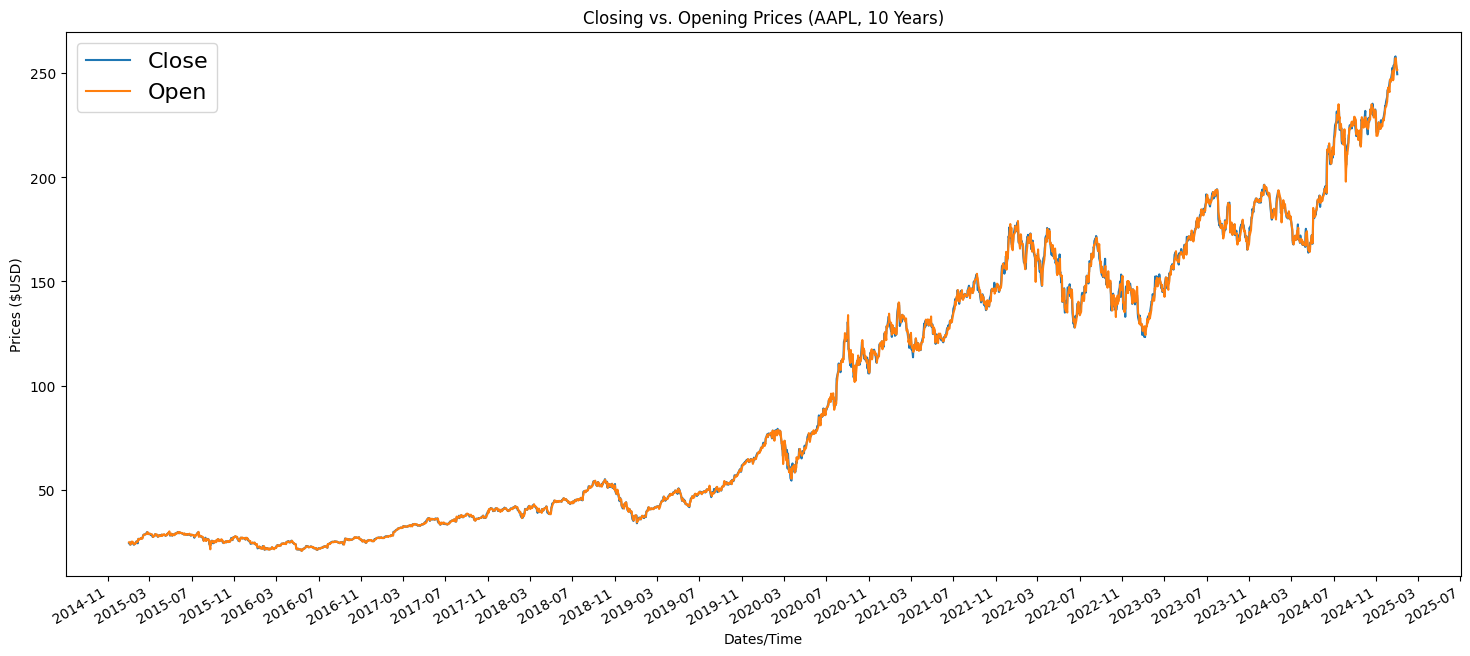

In [7]:
plt.figure(figsize = (18, 8)) 
plt.plot(dates, closing_prices, label = 'Close')
plt.plot(dates, opening_prices, label = 'Open')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Closing vs. Opening Prices (AAPL, 10 Years)')
plt.xlabel('Dates/Time')
plt.ylabel('Prices ($USD)')
plt.legend(fontsize = 16)

plt.gcf().autofmt_xdate()
plt.show()

## LSTM Model for Predicting Closing Prices

### Creating Training and Test Sets

- We will be using a training/test split of .80/.20
- We will be using a window/sequence length of 60 days

In [62]:
close_data = news_data[['Close']].values

training_amount = .8
training_index  = int(np.ceil(len(close_data) * training_amount))

window = 60

close_training_data = close_data[0:training_index]
close_test_data = close_data[training_index-window:]

### Processing Data

- We are gonna scale the data now using sklearn's **MinMaxScaler()**
- Only gonna transform on test or else the model would use knowledge of the test distribution too (prevent data leakage)

In [63]:
scaler = MinMaxScaler(feature_range = (-1, 1))
training_scaled = scaler.fit_transform(close_training_data.reshape(-1, 1))
testing_scaled = scaler.transform(close_test_data.reshape(-1, 1))

- Below is a function **make_data(X, window)** defined to help create our training/test sets

In [64]:
def make_data(X, window):
    X_output, y_output = [], []
    for i in range(window, len(X)):
        X_output.append(X[i - window:i])
        y_output.append(X[i])
    return np.array(X_output), np.array(y_output)

In [65]:
X_train, y_train = make_data(training_scaled, window)
X_test, y_test = make_data(testing_scaled, window)

### Building LSTM Model
- Preparing dataset for training in Pytorch

In [66]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

- We will be using a batch size of 64

In [67]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [68]:
# to get this run to on gpu
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [69]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 60, 1]) torch.Size([64, 1])


- We will use a hidden size of 64
- We will use 1 LSTM layer

In [70]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.LSTM = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.LSTM(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# LSTM(input size, hidden size, number of stacked layers)

model = LSTM(1, 64, 1)
model.to(device)
model

LSTM(
  (LSTM): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

### Fitting on Train Data and Performance Evaluation

- We will use a learning rate of .001
- We will be using MSE as a loss function and evaluating with RMSE after 

In [72]:
learning_rate = .001
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# remember we made our batch_size = 64

In [73]:
def train_epoch():
    model.train()
    print(f'Epoch: {1 + epoch}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print()
    
def validate_epoch():
    model.eval() 
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
    average_loss_across_batches = running_loss / len(test_loader)
    
    print(f'Validation Loss: {average_loss_across_batches}')
    print('-------------------------------------')
    print()

In [74]:
num_epochs = 50
for epoch in range(num_epochs):
    train_epoch()
    validate_epoch()

Epoch: 1

Validation Loss: 1.2309220656752586
-------------------------------------

Epoch: 2

Validation Loss: 0.17170903377700597
-------------------------------------

Epoch: 3

Validation Loss: 0.13974257791414857
-------------------------------------

Epoch: 4

Validation Loss: 0.11181598319672048
-------------------------------------

Epoch: 5

Validation Loss: 0.08878304937388748
-------------------------------------

Epoch: 6

Validation Loss: 0.06775673211086541
-------------------------------------

Epoch: 7

Validation Loss: 0.05557485460303724
-------------------------------------

Epoch: 8

Validation Loss: 0.051600043661892414
-------------------------------------

Epoch: 9

Validation Loss: 0.040001097426284105
-------------------------------------

Epoch: 10

Validation Loss: 0.03780387295410037
-------------------------------------

Epoch: 11

Validation Loss: 0.034466987824998796
-------------------------------------

Epoch: 12

Validation Loss: 0.02636011378490366
--

In [75]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy() # predictions
    actual = y_test.cpu().numpy() # ground truth

rescaled_predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
rescaled_actual = scaler.inverse_transform(actual.reshape(-1, 1))
rmse = mean_squared_error(rescaled_predicted, rescaled_actual) ** .5
print('RMSE: ', rmse)

RMSE:  5.156126263607656


#### Initial Model: RMSE = 5.156

## Plotting our Predicted Closing Prices Against the Ground Truth

In [76]:
train = news_data[:training_index]
test = news_data[training_index:]
test['Prediction'] = rescaled_predicted

/var/folders/h8/z8ls76px3n11bpkkm477797c0000gn/T/ipykernel_13345/307962552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = rescaled_predicted


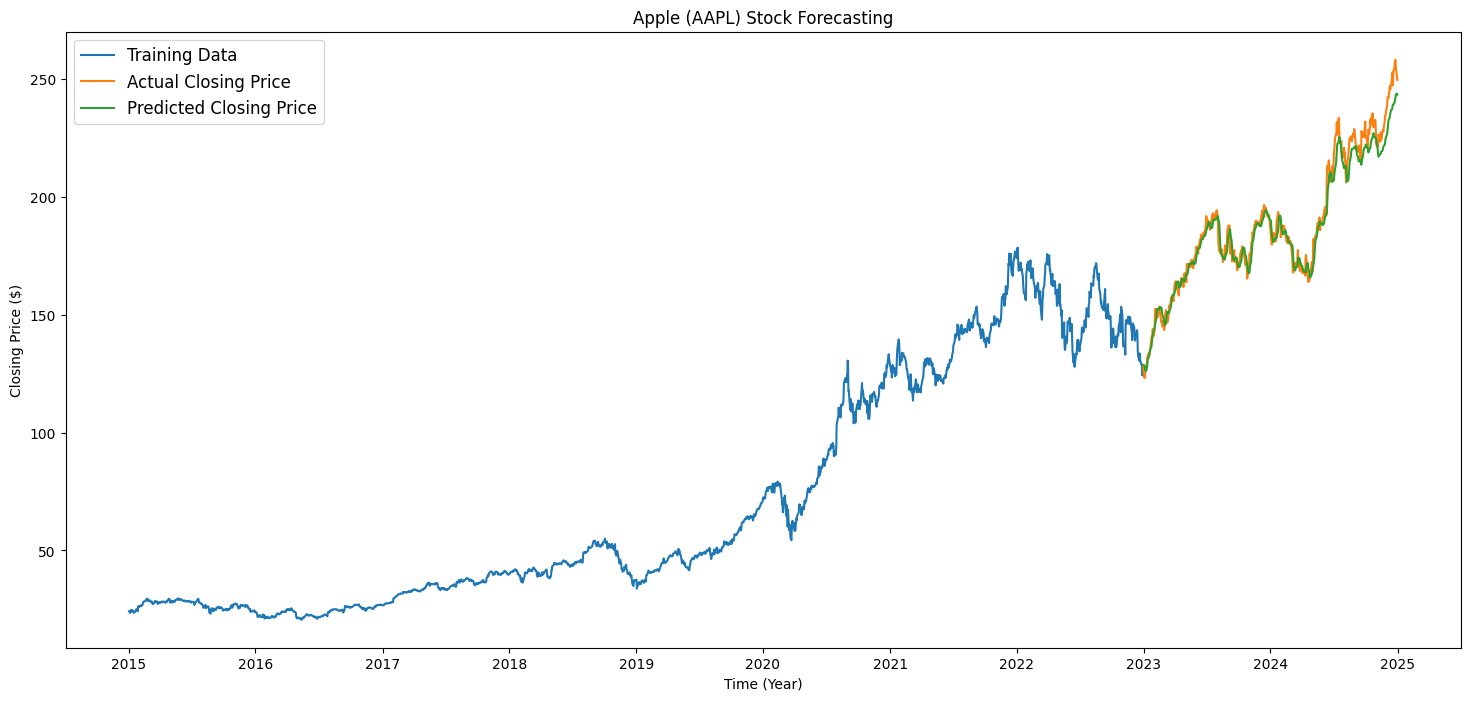

In [77]:
plt.figure(figsize = (18, 8))
plt.title("Apple (AAPL) Stock Forecasting")
plt.plot(train['Close'], label = 'Training Data')
plt.plot(test['Close'], label = 'Actual Closing Price')
plt.plot(test['Prediction'], label = 'Predicted Closing Price')
plt.xlabel('Time (Year)')
plt.ylabel('Closing Price ($)')
plt.legend(fontsize = 12)
plt.show()

## Tuning Hyperparameters

We are gonna tune the following hyperparameters:
- **Window/Sequence Length** (how many days prior the model sees)
- **Batch Size** (number of training points/data in one pass)
- **Hidden Size** ("memory" of each LSTM layer)
- **Learning Rate** (how big the update step it is)
- **Number of Epochs** (controls how much data is trained)

We will find the best hyperparameters and train the model again to potentially improve performance (achieve a lower RMSE)

In [78]:
parameter_grid = {
    "window":      [60, 90],
    "batch_size":  [32, 64],
    "hidden_size": [32, 64, 128],
    "num_layers":  [1, 2],
    "lr":          [1e-3],
    "num_epochs":  [20, 30]
}

In [79]:
def rebuild_loaders(window, batch_size, train_series, val_series):
    X_train, y_train = make_data(train_series, window)
    X_val, y_val = make_data(val_series, window)

    train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
    val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
    return train_loader, val_loader

val_amount = .1
n = len(close_training_data)
train_index = int(np.ceil((1 - val_amount) * n))
train_series = close_training_data[:train_index]
max_window = max(parameter_grid['window'])
val_series   = close_training_data[train_index - max_window:]  

def validate_epoch_2(loader):
    model.eval() 
    running_loss = 0.0

    for batch_index, batch in enumerate(loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
    average_loss_across_batches = running_loss / len(loader)
    return average_loss_across_batches

def train_validate(num_epochs, train_loader, val_loader):
    best_val = float('inf')
    for epoch in range(num_epochs):
        model.train()
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        val = validate_epoch_2(val_loader)
        if val < best_val:
            best_val = val
    return best_val

best = (float('inf'), None)
for w in parameter_grid["window"]:
    for b in parameter_grid["batch_size"]:
        
        train_loader, val_loader = rebuild_loaders(w, b, train_series, val_series)

        for h in parameter_grid["hidden_size"]:
            for num in parameter_grid["num_layers"]:
                for lr in parameter_grid["lr"]:
                    for epochs in parameter_grid["num_epochs"]:
                        model = LSTM(input_size = 1, hidden_size = h, num_stacked_layers = num).to(device)
                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                        val_loss = train_validate(epochs, train_loader, val_loader)
                        print(f"Window: {w}, Batch Size: {b}, Hidden Size: {h}, \nNumber of layers: {num}, Learning rate: {lr}, Epochs: {epochs} \nValidation Loss: {val_loss:.6f}")
                        print('-------------------------------------')

                        if val_loss < best[0]:
                            best = (val_loss, {"window": w, "batch_size": b, "hidden_size": h,
                                               "num_layers": num, "lr": lr, "num_epochs": epochs})

print("\nBest Hyperparameters:", best[1], "Validation Loss", best[0])

Window: 60, Batch Size: 32, Hidden Size: 32, 
Number of layers: 1, Learning rate: 0.001, Epochs: 20 
Validation Loss: 13104.966919
-------------------------------------
Window: 60, Batch Size: 32, Hidden Size: 32, 
Number of layers: 1, Learning rate: 0.001, Epochs: 30 
Validation Loss: 10207.904114
-------------------------------------
Window: 60, Batch Size: 32, Hidden Size: 32, 
Number of layers: 2, Learning rate: 0.001, Epochs: 20 
Validation Loss: 13184.979614
-------------------------------------
Window: 60, Batch Size: 32, Hidden Size: 32, 
Number of layers: 2, Learning rate: 0.001, Epochs: 30 
Validation Loss: 10794.136292
-------------------------------------
Window: 60, Batch Size: 32, Hidden Size: 64, 
Number of layers: 1, Learning rate: 0.001, Epochs: 20 
Validation Loss: 7788.962036
-------------------------------------
Window: 60, Batch Size: 32, Hidden Size: 64, 
Number of layers: 1, Learning rate: 0.001, Epochs: 30 
Validation Loss: 4689.642761
--------------------------

### Tuned Hyperparameters
- window = 60
- batch_size = 32
- hidden_size = 128
- num_layers = 1
- learning_rate = .001
- num_epochs = 30

**In our custom grid search, a combination of these hyperparameters achieved a **validation loss of ~996.7**

In [82]:
best_w = 60
best_bs = 32
best_h = 128
best_num_l = 1 
best_lr = .001
best_num_e = 30

In [83]:
close_data = news_data[['Close']].values

training_amount = .8
training_index  = int(np.ceil(len(close_data) * training_amount))

window = best_w

final_close_training_data = close_data[0:training_index]
final_close_test_data = close_data[training_index-window:]

In [84]:
final_training_scaled = scaler.fit_transform(final_close_training_data.reshape(-1, 1))
final_testing_scaled = scaler.transform(final_close_test_data.reshape(-1, 1))

In [85]:
final_X_train, final_y_train = make_data(final_training_scaled, window)
final_X_test, final_y_test = make_data(final_testing_scaled, window)

In [86]:
final_X_train = torch.tensor(final_X_train).float()
final_X_test = torch.tensor(final_X_test).float()
final_y_train = torch.tensor(final_y_train).float()
final_y_test = torch.tensor(final_y_test).float()

In [87]:
final_train_dataset = TensorDataset(final_X_train, final_y_train)
final_test_dataset = TensorDataset(final_X_test, final_y_test)

final_train_loader = DataLoader(final_train_dataset, batch_size = best_bs, shuffle = True)
final_test_loader = DataLoader(final_test_dataset, batch_size = best_bs, shuffle = False)

In [88]:
for _, batch in enumerate(final_train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([32, 60, 1]) torch.Size([32, 1])


In [94]:
def final_train_epoch():
    final_model.train()
    print(f'Epoch: {1 + epoch}')
    running_loss = 0.0

    for batch_index, batch in enumerate(final_train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = final_model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print()
    
def final_validate_epoch():
    final_model.eval() 
    running_loss = 0.0

    for batch_index, batch in enumerate(final_test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = final_model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
            
    average_loss_across_batches = running_loss / len(final_test_loader)
    
    print(f'Validation Loss: {average_loss_across_batches}')
    print('-------------------------------------')
    print()

In [95]:
final_model = LSTM(1, best_h, best_num_l)
final_model.to(device)
final_model

LSTM(
  (LSTM): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [96]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr = best_lr)

In [97]:
for epoch in range(best_num_e):
    final_train_epoch()
    final_validate_epoch()

Epoch: 1

Validation Loss: 0.09767703426769003
-------------------------------------

Epoch: 2

Validation Loss: 0.07265945259132423
-------------------------------------

Epoch: 3

Validation Loss: 0.04247945798852015
-------------------------------------

Epoch: 4

Validation Loss: 0.03516624734038487
-------------------------------------

Epoch: 5

Validation Loss: 0.019267726136604324
-------------------------------------

Epoch: 6

Validation Loss: 0.012716080636892002
-------------------------------------

Epoch: 7

Validation Loss: 0.01708674280962441
-------------------------------------

Epoch: 8

Validation Loss: 0.017402675657649525
-------------------------------------

Epoch: 9

Validation Loss: 0.013478667213348672
-------------------------------------

Epoch: 10

Validation Loss: 0.006562976253917441
-------------------------------------

Epoch: 11

Validation Loss: 0.004763568191265222
-------------------------------------

Epoch: 12

Validation Loss: 0.0276964562654029

In [99]:
with torch.no_grad():
    final_predicted = final_model(final_X_test.to(device)).to('cpu').numpy() # predictions
    final_actual = final_y_test.cpu().numpy() # ground truth

final_rescaled_predicted = scaler.inverse_transform(final_predicted.reshape(-1, 1))
final_rescaled_actual = scaler.inverse_transform(final_actual.reshape(-1, 1))
final_rmse = mean_squared_error(final_rescaled_predicted, final_rescaled_actual) ** .5
print('RMSE: ', final_rmse)

RMSE:  4.423452790024021


In [101]:
rmse, final_rmse

(5.156126263607656, 4.423452790024021)

## **After tuning hyperparameters, we reduced the test RMSE to ~4.423, an improvement in our model's performance! 🎉 🥳**

## Final Plot

In [102]:
final_train = news_data[:training_index]
final_test = news_data[training_index:]
final_test['Prediction'] = final_rescaled_predicted

/var/folders/h8/z8ls76px3n11bpkkm477797c0000gn/T/ipykernel_13345/662713494.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test['Prediction'] = final_rescaled_predicted


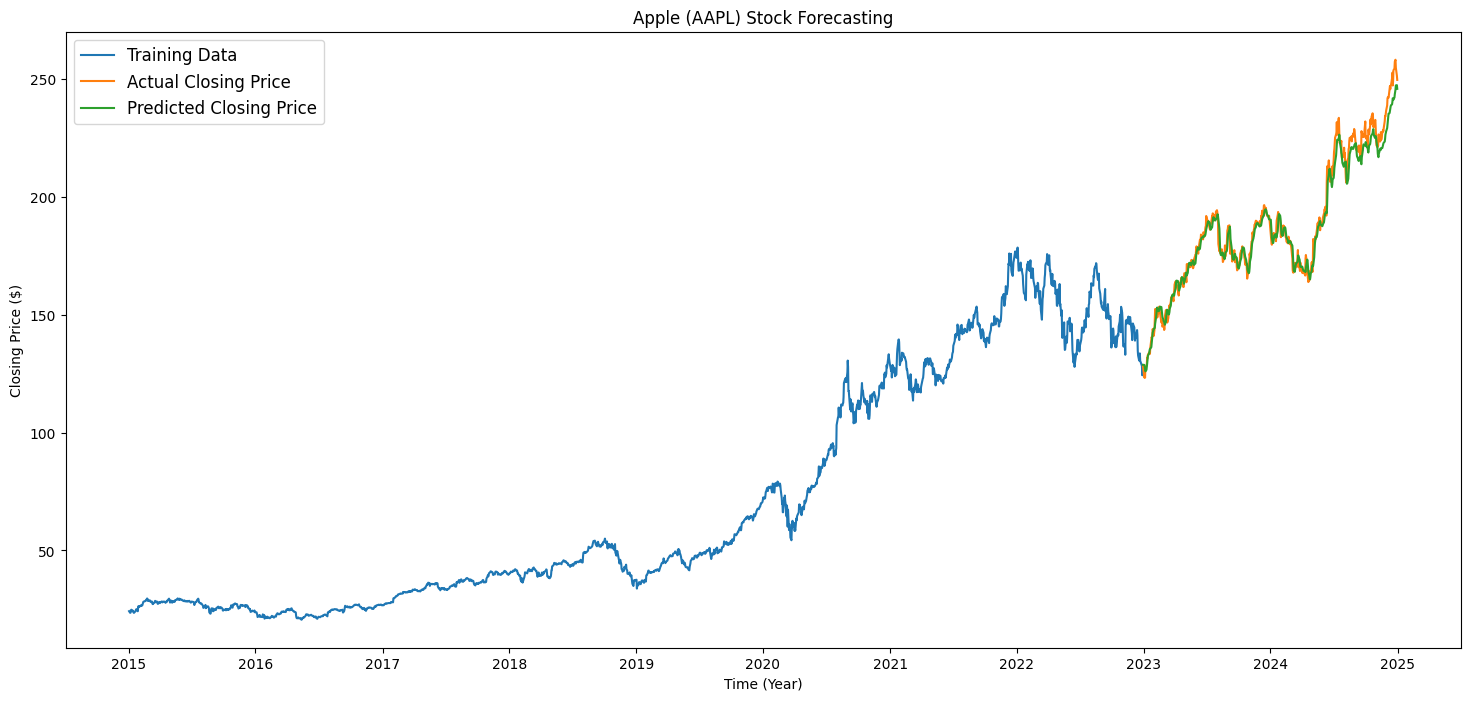

In [103]:
plt.figure(figsize = (18, 8))
plt.title("Apple (AAPL) Stock Forecasting")
plt.plot(final_train['Close'], label = 'Training Data')
plt.plot(final_test['Close'], label = 'Actual Closing Price')
plt.plot(final_test['Prediction'], label = 'Predicted Closing Price')
plt.xlabel('Time (Year)')
plt.ylabel('Closing Price ($)')
plt.legend(fontsize = 12)
plt.show()

As we can see above, the model is able to predict stock prices well from a visual standpoint (see graph above). However, there are many other factors (market sentiment, economic indicators, breaking news, etc.) that prohibit a model like this to be very effective. A practical and usable stock forecasting model is difficult to build because of how much noise and movement there is in the market. 

If we revisit this project in the future, we can reframe this task to instead predict log returns, which makes the time series more stationary and will capture relative change instead of direct prices.